### Symmetric Quantization

In [ ]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = torch.max(torch.abs(X)) / 127

    # Quantize
    X_quant = (X / scale).round()

    # Dequantize
    X_dequant = X_quant * scale

    return X_quant.to(torch.int8), X_dequant

In [ ]:
sample_data = torch.tensor([0.3, 0.6, -0.3, -0.5, 0.0, 0.7, -0.8, 0.2])

In [ ]:
absmax_quantize(sample_data)

(tensor([  48,   95,  -48,  -79,    0,  111, -127,   32], dtype=torch.int8),
 tensor([ 0.3024,  0.5984, -0.3024, -0.4976,  0.0000,  0.6992, -0.8000,  0.2016]))

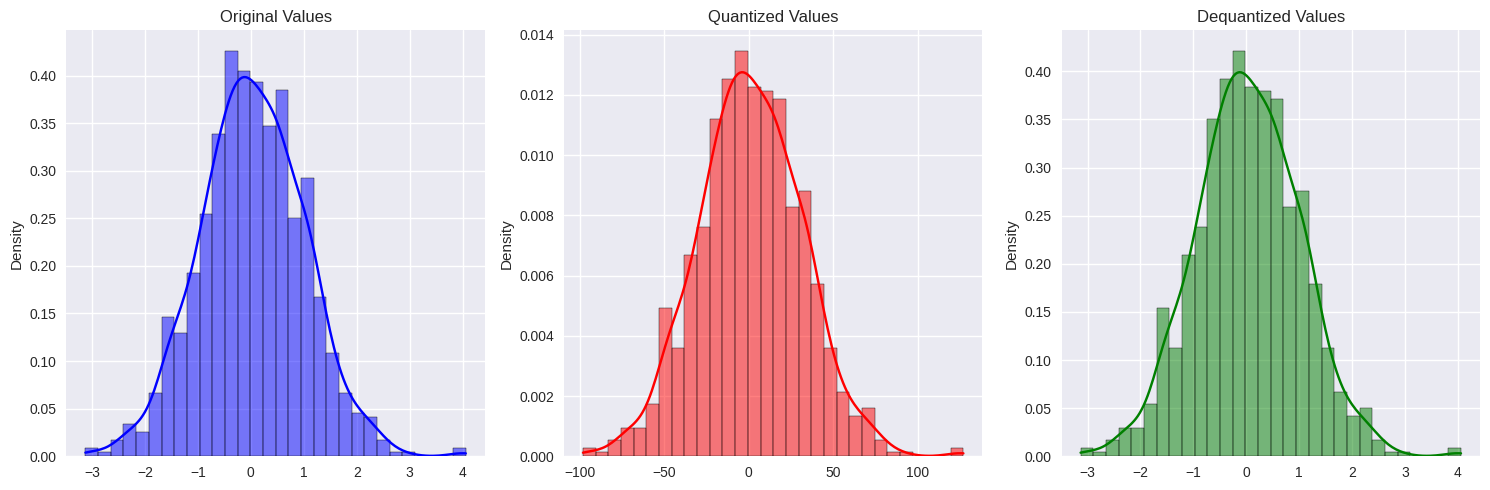

In [ ]:
import seaborn as sns
# Generate some random data
X = torch.randn(1000)  # You can adjust the size and distribution as needed

# Quantize and dequantize
X_quant, X_dequant = absmax_quantize(X)

# Convert tensors to numpy for plotting
X_np = X.numpy()
X_quant_np = X_quant.numpy().astype(float)  # Convert to float for plotting
X_dequant_np = X_dequant.numpy()

# Plotting
plt.figure(figsize=(15, 5))

# Original values
plt.subplot(1, 3, 1)
sns.histplot(X_np, kde=True, color='blue', stat='density', bins=30)
plt.title('Original Values')

# Quantized values
plt.subplot(1, 3, 2)
sns.histplot(X_quant_np, kde=True, color='red', stat='density', bins=30)
plt.title('Quantized Values')

# Dequantized values
plt.subplot(1, 3, 3)
sns.histplot(X_dequant_np, kde=True, color='green', stat='density', bins=30)
plt.title('Dequantized Values')

plt.tight_layout()
plt.show()

In [ ]:
def visualize_over_original(X_np, X_dequant_np):

    # Histogram of the original values
    plt.subplot(1, 2, 1)
    plt.hist(X_np, bins=30, alpha=0.6, label='Original')
    plt.hist(X_dequant_np, bins=30, alpha=0.6, label='Dequantized')
    plt.title('Distribution of Original and Dequantized Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

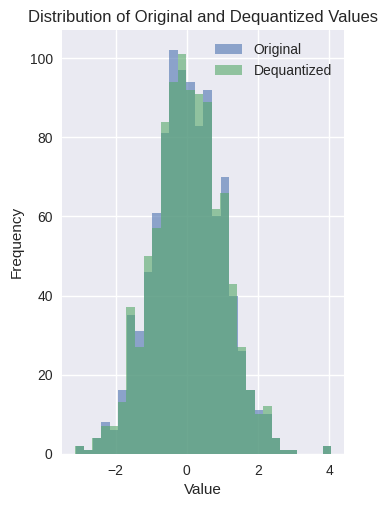

In [ ]:
visualize_over_original(X_np, X_dequant_np)

### Asymmetric Quantization

In [ ]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = x_range / 255

    # Shift by zero-point
    zeropoint = (torch.min(X) / scale).round() + 128

    # Scale and round the inputs
    X_quant = torch.clip((X / scale - zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant + zeropoint) * scale

    return X_quant.to(torch.int8), X_dequant

In [ ]:
sample_data = torch.tensor([0.3, 0.6, -0.3, -0.5, 0.0, 0.7, -0.8, 0.2])
zeropoint_quantize(sample_data)

(tensor([  59,  110,  -43,  -77,    8,  127, -128,   42], dtype=torch.int8),
 tensor([ 0.3000,  0.6000, -0.3000, -0.5000,  0.0000,  0.7000, -0.8000,  0.2000]))

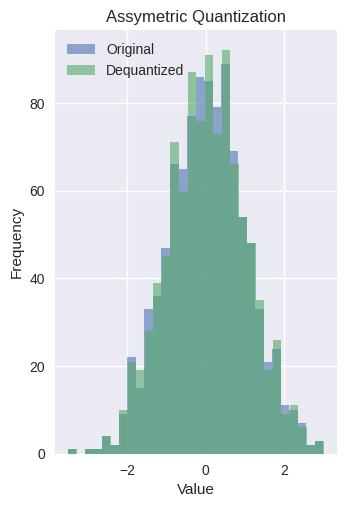

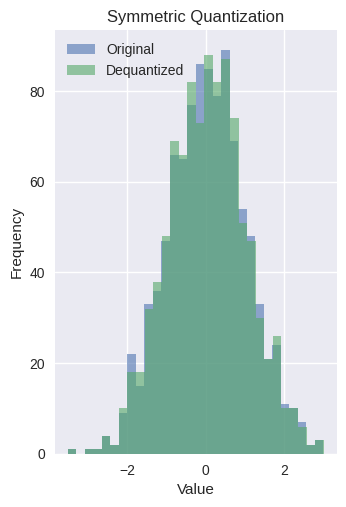

In [ ]:
import seaborn as sns
# Generate some random data
X = torch.randn(1000)  # You can adjust the size and distribution as needed

# Quantize and dequantize
X_quant_zp, X_dequant_zp = zeropoint_quantize(X)
X_quant_am, X_dequant_am = absmax_quantize(X)

# Convert tensors to numpy for plotting
X_np = X.numpy()
X_quant_zp_np = X_quant_zp.numpy().astype(float)  # Convert to float for plotting
X_dequant_zp_np = X_dequant_zp.numpy()

X_quant_am_np = X_quant_am.numpy().astype(float)  # Convert to float for plotting
X_dequant_am_np = X_dequant_am.numpy()

visualize_over_original(X_np, X_dequant_zp_np)
plt.title('Assymetric Quantization')
plt.show()

visualize_over_original(X_np, X_dequant_am_np)
plt.title('Symmetric Quantization')
plt.show()

### Percentile Quantization

In [ ]:
def percentile_quantize(X, percentile=70):
    # Calculate the 99th percentile of the absolute values in X
    scale = torch.quantile(torch.abs(X), percentile/100.) / 127

    # Quantize
    X_quant = (X / scale).round()

    # Clamp the values to ensure they are within the int8 range after rounding
    X_quant = torch.clamp(X_quant, min=-128, max=127)

    # Dequantize
    X_dequant = X_quant * scale

    return X_quant.to(torch.int8), X_dequant

In [ ]:
sample_data = torch.tensor([0.3, 0.6, -0.3, -0.5, 0.0, 0.7, -99, 0.2])
percentile_quantize(sample_data)

(tensor([  65,  127,  -65, -108,    0,  127, -128,   43], dtype=torch.int8),
 tensor([ 0.3020,  0.5900, -0.3020, -0.5017,  0.0000,  0.5900, -0.5946,  0.1998]))

In [ ]:
absmax_quantize(sample_data)

(tensor([   0,    1,    0,   -1,    0,    1, -127,    0], dtype=torch.int8),
 tensor([  0.0000,   0.7795,  -0.0000,  -0.7795,   0.0000,   0.7795, -99.0000,
           0.0000]))

### Quantization for LLMs

In [ ]:
!pip install transformers
# install llamacpp
!git clone https://github.com/ggerganov/llama.cpp
!cd llama.cpp && git pull && make clean && LLAMA_CUBLAS=1 make
!pip install -r llama.cpp/requirements.txt
# install ctransformers
!CT_CUBLAS=1 pip install ctransformers --no-binary ctransformers
# install quantization package
!python -m pip install optimum
!pip install autoawq
!pip install auto-gptq
!pip install --upgrade accelerate
!pip install bitsandbytes

Cloning into 'llama.cpp'...
remote: Enumerating objects: 19385, done.
remote: Counting objects: 100% (19385/19385), done.
remote: Compressing objects: 100% (5761/5761), done.
remote: Total 19385 (delta 13723), reused 18980 (delta 13471), pack-reused 0
Receiving objects: 100% (19385/19385), 23.01 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (13723/13723), done.
Already up to date.
I ccache not found. Consider installing it for faster compilation.
I llama.cpp build info: 
I UNAME_S:   Linux
I UNAME_P:   x86_64
I UNAME_M:   x86_64
I CFLAGS:    -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG  -std=c11   -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wshadow -Wstrict-prototypes -Wpointer-arith -Wmissing-prototypes -Werror=implicit-int -Werror=implicit-function-declaration -pthread -march=native -mtune=native -Wdouble-promotion 
I CXXFLAGS:  -std=c++11 -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wmissing-declarations -Wmissing-noretur

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ctransformers: filename=ctransformers-0.2.27-cp310-cp310-linux_x86_64.whl size=2336807 sha256=cbb4a958c6855d0a4c61d539cdd73d01766dad6174eea583db71763a71179a61
  Stored in directory: /root/.cache/pip/wheels/dd/54/e9/32364da8eee84a2b0b412394983c15add18816c507e90f02d8
Successfully built ctransformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.1/407.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.

In [ ]:
from transformers import (
    AutoModel,
    AutoTokenizer,
    pipeline,
    AutoModelForCausalLM,
    GPTQConfig,
    AwqConfig,
    BitsAndBytesConfig
)

from huggingface_hub import snapshot_download
from ctransformers import AutoModelForCausalLM as CAutoModelForCausalLM
from optimum.gptq import GPTQQuantizer, load_quantized_model
from awq import AutoAWQForCausalLM
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
import torch
import time

from huggingface_hub import create_repo, HfApi
from google.colab import userdata, runtime
import os

ModuleNotFoundError: No module named 'ctransformers'

**1. Load model Without Quantization**

In [ ]:
# using huggingface from_pretrained
model_name = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'
model = AutoModel.from_pretrained(model_name, device_map='cuda') # lead to OOM in cuda mem

**2. Load model with Quantization**

gguf

In [ ]:
# using gguf
model_name = 'TheBloke/TinyLlama-1.1B-Chat-v1.0-GGUF'
# check ctransformers doc for more configs
config = {'max_new_tokens': 256, 'repetition_penalty': 1.1,
          'temperature': 0.1, 'stream': True}
llm = CAutoModelForCausalLM.from_pretrained(
      model_name,
      model_type="llama",
      #lib='avx2', for cpu use
      gpu_layers=110, #110 for 7b, 130 for 13b
      **config
      ) # only take 4.8 cuda mem

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tinyllama-1.1b-chat-v1.0.Q2_K.gguf:   0%|          | 0.00/483M [00:00<?, ?B/s]

awq

In [ ]:
# using awq
model_name = 'phatjk/vinallama-7b-chat-AWQ'
quantization_config = AwqConfig(
    bits=4,
    fuse_max_seq_len=512,
    do_fuse=True,
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config, device_map='auto')

NameError: name 'AwqConfig' is not defined

gptq

In [ ]:
# using GPTQ
model_name = 'TheBloke/LLaMa-7B-GPTQ'
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

NameError: name 'AutoModelForCausalLM' is not defined

bitsandbytes

In [ ]:
# using bitsandbyte
model_name = 'vilm/vinallama-7b-chat'
device_map = {
    "transformer.word_embeddings": 0, # 0 mean gpu
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": "cpu", # offload lm_head to cpu
    "transformer.h": 0,
    "transformer.ln_f": 0,
}
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)
model_nf4 = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=nf4_config)